# Pentathlon: Model recommending next product to buy (NPTB)

The next product to buy (NPTB) model uses predictive techniques to determine the product or product category that the customer is most likely to buy. Pentathlon is a sporting goods and apparel retailer and uses the NPTB model to determine which product category to advertise to a particular customer, and thus maximize the chance of purchase, and in turn maximize profits in comparison to a non-targeted/random messaging approach.

## Goal

Compare on basis of expected profit, several machine learning models against a logistic regression to determine which of the 7 product categories (Endurance, Water, Strength, Team, Backcountry, Racquet and Winter) is the selected message category for a particular customer.


In [1]:
from IPython.display import HTML

HTML('''

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="Show Python 3 Code">
</form>''')

## The Data

(courtesy Vincent Nijs - Rady School of Management - University of California San Diego, Florian Zettelmeyer - Northwestern University and Song Yao - Washington University in St. Louis)

- Balanced data set: 100000 with 50% of customers in the sample responding as 'yes'
- Additional unbalanced or true representative sample: 100000 with ~1% of customers in the sample responding as 'yes'
- Demographics are included (age, income, gender, # of children etc.)
- Total order size and order size per category (EUR spent by customer on order)
- Number of purchases per category by customer (frequency)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import PolynomialFeatures

#increase plot resolution
mpl.rcParams["figure.dpi"] = 100

# set number of cores if working on server
n_jobs = 2

## loading the data

pentathlon_nptb = pd.read_pickle("data/pentathlon_nptb.pkl")
pentathlon_nptb["buyer_yes"] = (pentathlon_nptb["buyer"] == "yes").astype(int)
pentathlon_nptb.head(5)

,custid,buyer,total_os,message,age,gender,income,education,children,freq_endurance,...,endurance_os,strength_os,water_os,team_os,backcountry_os,winter_os,racquet_os,training,representative,buyer_yes
0,U45198803,no,0.0,endurance,30 to 44,M,25000,14,1.3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
1,U22197752,no,0.0,backcountry,45 to 59,F,40000,44,0.4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
2,U83874832,no,0.0,backcountry,45 to 59,M,50000,24,0.8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,U19423462,no,0.0,winter,45 to 59,F,50000,26,1.1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
4,U23888305,no,0.0,winter,30 to 44,M,40000,22,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0


## Methodology

- With limited feature set, all features included in model
- Logistic regression made use of an interaction specifically the message sent against each of the other explanatory variables.
- Cross validation completed on models to tune hyper parameters
- Linear regression done to predict order size (EUR)
- 60% of revenue was COGS, 40% margin
- Expected profit calculated on the 100k representative sample and 5 million customer base

## Value to stakeholder

Recommending products through predicted modeling generates expected profit of EUR 26770 on 100k representative sample as compared to a random messaging approach which is expected to generate only EUR 18588, a 44% improvement.

Considering Pentathlon's typical e-mail blast to 5 million customers, the expected 'improvement' in profit from the modeling approach is EUR 409120 from using modeling approach.

## Why interaction of the message against the other features in the logistic model?

Endurance has the highest response rate, without interactions, every logistic regression's prediction (i.e. recommended product category) for a new customer would simply be 'endurance'

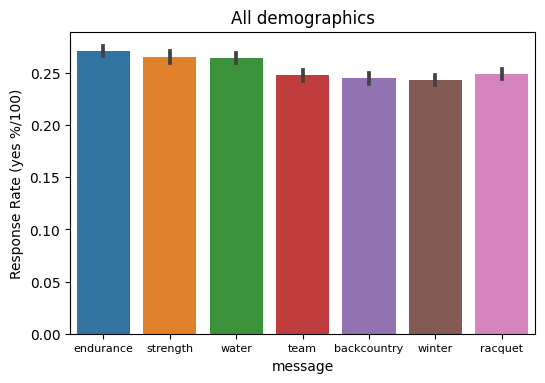

In [121]:
plot1 = sns.barplot(data = pentathlon_nptb, x = pentathlon_nptb['message'], y = pentathlon_nptb['buyer_yes'])
plot1.set(ylabel="Response Rate (yes %/100)")
plot1.set(title="All demographics")
for item in (plot1.get_xticklabels()):
    item.set_fontsize(8)

With interactions, for example in the Age Group '30 to 44', strength has higher response and such interaction effects need to be reflected in the model

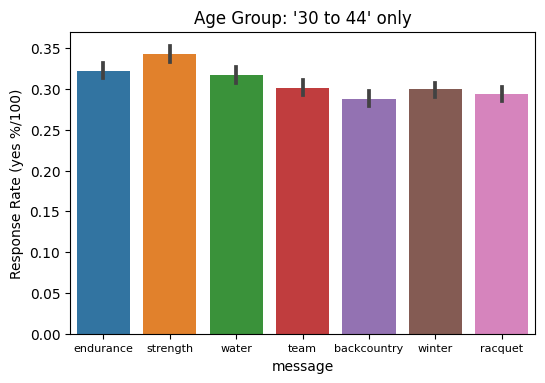

In [120]:
plot2 = sns.barplot(data = pentathlon_nptb, x = pentathlon_nptb.query("age == '30 to 44'")['message'], y = pentathlon_nptb.query("age == '30 to 44'")['buyer_yes'])
plot2.set(ylabel="Response Rate (yes %/100)", title="Age Group: '30 to 44' only")

for item in (plot2.get_xticklabels()):
    item.set_fontsize(8)

In [5]:
# Data type setting and dummy variable creation and scaling

pentathlon_nptb[["message", "age", "gender"]] = pentathlon_nptb[["message", "age", "gender"]].astype("category")

# true response rate is 1% (yes), 99%(no), adding a weights column to the dataset for scaling and modeling purposes:
pentathlon_nptb["cweight"] = rsm.ifelse(pentathlon_nptb.buyer == "yes", 1, 99)

pentathlon_nptb.dtypes

custid                object
buyer               category
total_os             float64
message             category
age                 category
gender              category
income                 int32
education              int32
children             float64
freq_endurance         int32
freq_strength          int32
freq_water             int32
freq_team              int32
freq_backcountry       int32
freq_winter            int32
freq_racquet           int32
endurance_os         float64
strength_os          float64
water_os             float64
team_os              float64
backcountry_os       float64
winter_os            float64
racquet_os           float64
training               int32
representative         int32
buyer_yes              int64
cweight                int64
dtype: object

In [6]:
dummies = ["message", "age", "gender", "training"]

resp = ["buyer_yes", "training"]

rvar = "buyer_yes"

evar_std = ['income', 'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet']
            
idvar = "custid"
lev = 1

eval_dat = pentathlon_nptb[[idvar, rvar, "training"]]

In [7]:
# the below requires pyrsm version 0.4.2 or greater
rsm.__version__

'0.4.6'

In [8]:
X = pd.concat([pentathlon_nptb[evar_std], pd.get_dummies(pentathlon_nptb[dummies])], axis=1)
y = pentathlon_nptb[resp]

Note about scaling:
    
- pyrsm's scale_df is a superior scaling function as comapared to sci-kit learn's standard scaler
- pyrsm uses a default 2 x s.d. to correct the continuous variables thus making the interpretation of a '2 s.d. unit increase corresponding to a x coefficient increase' consistent across categorical variables 
- max s.d. of a categorical variable is 0.5, i.e., 1 s.d. unit. However, when a categorical variable value changes from 0 to 1, that corresponds to a change of 2 s.d. units.
(see Andrew Gelman's "SCALING REGRESSION INPUTS BY DIVIDING BY TWO STANDARD DEVIATIONS")
- pyrsm incorporates weights to correct standardize according to the data unbalance

In [9]:
Xs = rsm.scale_df(X, train=pentathlon_nptb.training == 1, excl=pd.get_dummies(pentathlon_nptb[dummies]).columns, wt = pentathlon_nptb['cweight'])
Xs.columns

Index(['income', 'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet', 'training', 'message_endurance', 'message_strength',
       'message_water', 'message_team', 'message_backcountry',
       'message_winter', 'message_racquet', 'age_< 30', 'age_30 to 44',
       'age_45 to 59', 'age_>= 60', 'gender_M', 'gender_F'],
      dtype='object')

In [10]:
Xs = Xs.rename(columns={'age_< 30': 'age_less_than_30', 'age_>= 60': 'age_greater_than_60'})
Xs.columns

Index(['income', 'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet', 'training', 'message_endurance', 'message_strength',
       'message_water', 'message_team', 'message_backcountry',
       'message_winter', 'message_racquet', 'age_less_than_30', 'age_30 to 44',
       'age_45 to 59', 'age_greater_than_60', 'gender_M', 'gender_F'],
      dtype='object')

In [11]:
Xs_train = Xs.query('training == 1')
Xs_train = Xs_train.drop('training', axis = 1)

Xs_test = Xs.query('training == 0')
Xs_test = Xs_test.drop('training', axis = 1)

Xs_rep = Xs.query('training != 0 and training != 1')
Xs_rep = Xs_rep.drop('training', axis = 1)

y_train = y.query('training == 1')
y_train = y_train.drop('training', axis = 1)

y_test = y.query('training == 0')
y_test = y_test.drop('training', axis = 1)

y_rep = y.query('training != 0 and training != 1')
y_rep = y_rep.drop('training', axis = 1)

Xs = Xs.drop('training', axis = 1)

In [12]:
pentathlon_nptb.columns

Index(['custid', 'buyer', 'total_os', 'message', 'age', 'gender', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet', 'endurance_os', 'strength_os', 'water_os', 'team_os',
       'backcountry_os', 'winter_os', 'racquet_os', 'training',
       'representative', 'buyer_yes', 'cweight'],
      dtype='object')

## Statsmodel GLM

In [13]:
# Simple code to avoid typing in features in logit model

logit_features = ['message', 'age', 'gender', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_winter',
       'freq_racquet', 'message:age', 'message:gender', 'message:income', 'message:education','message:children', 
                  'message : freq_endurance', 'message : freq_strength',
       'message : freq_water', 'message : freq_team', 'message: freq_backcountry', 'message : freq_winter']

logit_model = "buyer_yes ~ "
for feat in logit_features:
        logit_model = logit_model + feat + " + "

logit_model = logit_model[:-3]

logit_model

'buyer_yes ~ message + age + gender + income + education + children + freq_endurance + freq_strength + freq_water + freq_team + freq_backcountry + freq_winter + freq_racquet + message:age + message:gender + message:income + message:education + message:children + message : freq_endurance + message : freq_strength + message : freq_water + message : freq_team + message: freq_backcountry + message : freq_winter'

In [14]:


lr = smf.glm(
 formula=logit_model,
 family=Binomial(link=logit()),
 data=pentathlon_nptb.query("training == 1"),
 freq_weights=pentathlon_nptb.query("training == 1")["cweight"],
).fit(cov_type="HC1")
#lr.summary() 

In [15]:
#pentathlon_nptb["p_buyer_yes"] = lr.predict(pentathlon_nptb)

eval_dat = eval_dat.assign(y_glm=lr.predict(pentathlon_nptb))

#response rate for the representative sample:
print("Response rate for the representative sample is: ", round(eval_dat[eval_dat.training == -2147483648].y_glm.mean()*100 , 2), "%")

rsm.or_ci(lr)

Response rate for the representative sample is:  1.04 %


,index,OR,OR%,2.5%,97.5%,p.values,
1,message[T.strength],0.558,-44.2%,0.455,0.684,< .001,***
2,message[T.water],0.848,-15.2%,0.693,1.039,0.111,
3,message[T.team],0.876,-12.4%,0.718,1.070,0.195,
4,message[T.backcountry],0.903,-9.7%,0.738,1.106,0.325,
5,message[T.winter],0.549,-45.1%,0.445,0.678,< .001,***
...,...,...,...,...,...,...,...
94,message[T.team]:freq_winter,1.313,31.3%,1.168,1.476,< .001,***
95,message[T.backcountry]:freq_winter,0.950,-5.0%,0.843,1.070,0.396,
96,message[T.winter]:freq_winter,1.906,90.6%,1.698,2.139,< .001,***
97,message[T.racquet]:freq_winter,1.042,4.2%,0.922,1.177,0.511,


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

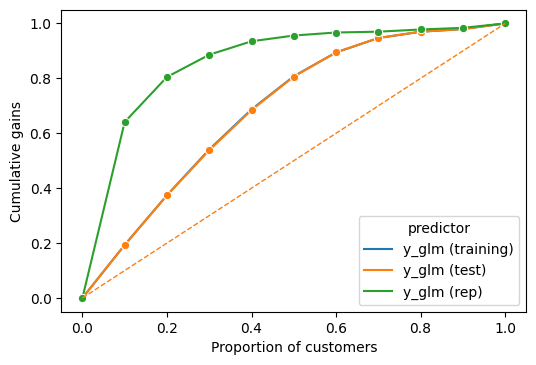

In [16]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
    "rep": eval_dat[eval_dat.training == -2147483648]
}

rsm.gains_plot(dct, rvar, lev, pred = 'y_glm', qnt=10, marker="o")

- No indication of overfitting - test and train align
- Representative sample is unbalanced with 1% of the sample likely to respond. It is expected that the top decile is going to yield the majority of the responses.

## SciKit Learn Logistic Model

The output from a logistic regression model without interactions are explored here:

In [17]:
clf_lr = LogisticRegression(random_state=1234, max_iter=1000, solver="saga", penalty="l1", class_weight = {0: 99/100, 1: 1/100})
param_grid_lr = {"C": [0.75]}
#param_grid_lr = {"C": [1.5, 1.25, 1, 0.75, 0.5]}
lr_cv = GridSearchCV(clf_lr, param_grid_lr, cv=5, scoring="roc_auc")
lr_cv.fit(Xs_train, y_train.buyer_yes)

# results from CV for logistic regression with regularization
cv_results = pd.DataFrame(lr_cv.cv_results_).sort_values(by=["rank_test_score"])
print('Optimal Parameter, L1')
cv_results.iloc[0, cv_results.columns.get_loc("param_C")]

Optimal Parameter, L1


0.75

In [18]:
lr_best = LogisticRegression(
    random_state=1234,
    max_iter=1000,
    solver="saga",
    penalty="l1",
    C=cv_results.iloc[0, cv_results.columns.get_loc("param_C")],
    class_weight = {0: 99/100, 1: 1/100}
).fit(Xs_train, y_train.buyer_yes)

eval_dat = eval_dat.assign(
    y_lasso=lr_best.predict_proba(Xs)[:, 1]
)

#response rate for the representative sample:
print("Response rate for the representative sample is: ", round(eval_dat[eval_dat.training == -2147483648].y_lasso.mean()*100 , 2), "%")

#coef = lr_best.coef_
#pd.DataFrame({"labels": Xs.columns, "coefficients": coef[0], "OR": np.exp(coef[0])})

Response rate for the representative sample is:  1.01 %


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

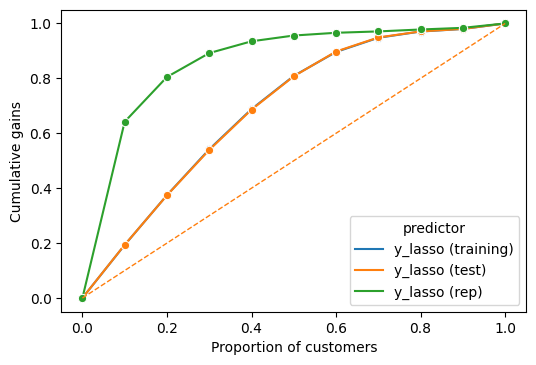

In [19]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
    "rep": eval_dat[eval_dat.training == -2147483648]
}

rsm.gains_plot(dct, rvar, lev, pred = 'y_lasso', qnt=10, marker="o")

No indication of overfitting - test and train align

## Neural Network

- cross validation has been completed with a range of hyper parameters to select one with highest AUC
- no provision for applying case weights in sci kit learn's neural network MLP clssifier, thus predicted response will be exaggerated

In [20]:
nr_hnodes = range(1, 5) 
hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
hls = (4,4) # selected 2 hidden layers with 4 nodes in each

In [21]:
param_grid_nn = {
    'hidden_layer_sizes': hls,
    'alpha': [0.75]
    #'alpha': [0.25, 0.5, 0.75, 1.0] #cross validation has been completed with a range of hyper parameters to select one with highest AUC
}
scoring = {'AUC': 'roc_auc'}



clf_nn = MLPClassifier(
    activation="tanh",
    solver="lbfgs",
    alpha=0.01,
    hidden_layer_sizes=(1,),
    random_state=1234,
    max_iter=10000
).fit(Xs_train, y_train.buyer_yes)

clf_nn_cv = GridSearchCV(
    clf_nn, param_grid_nn, scoring=scoring, cv=5, n_jobs=n_jobs, refit='AUC', verbose=5
)
clf_nn_cv.fit(Xs_train, y_train.buyer_yes)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                     hidden_layer_sizes=(1,), max_iter=10000,
                                     random_state=1234, solver='lbfgs'),
             n_jobs=2,
             param_grid={'alpha': [0.75], 'hidden_layer_sizes': (4, 4)},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [22]:
cv_results = pd.DataFrame(clf_nn_cv.cv_results_).sort_values(by='rank_test_AUC')

print ('Optimal hyper parameters are:')

cv_results.iloc[
    0,
    [cv_results.columns.get_loc(c) for c in ['param_alpha', 'param_hidden_layer_sizes']],
]

Optimal hyper parameters are:


param_alpha                 0.75
param_hidden_layer_sizes       4
Name: 0, dtype: object

In [26]:
print("Making sure order of categorical response is correct, expect [0: no, 1: yes]")
print(clf_nn_cv.classes_)

Making sure order of categorical response is correct, expect [0: no, 1: yes]
[0 1]


In [27]:
eval_dat = eval_dat.assign(
        y_nn_cv=clf_nn_cv.best_estimator_.predict_proba(Xs)[:, 1]
    )

#response rate for the representative sample:
print("Response rate for the representative sample is: ", round(eval_dat[eval_dat.training == -2147483648].y_nn_cv.mean()*100 , 2), "%")

Response rate for the representative sample is:  27.02 %


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

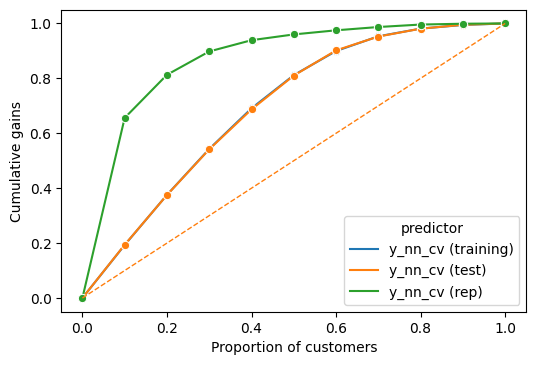

In [28]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
    "rep": eval_dat[eval_dat.training == -2147483648]
}

rsm.gains_plot(dct, rvar, lev, pred = 'y_nn_cv', qnt=10, marker="o")

No indication of overfitting - test and train align

## Random Forest

- case weights attempted to be applied in random forest
- cross validation has been completed with a range of hyper parameters to select one with highest AUC

In [29]:
clf_rf = RandomForestClassifier(class_weight = {0: 99, 1: 1}) 
param_grid_rf = {
    "n_estimators": [400],
    #"n_estimators": list(range(100, 401, 100)), #cross validation has been completed with a range of hyper parameters to select one with highest AUC
    "max_features": [4],
    #"max_features": range(3, 6), 
}
scoring = {"AUC": "roc_auc"}
param_grid_rf

{'n_estimators': [400], 'max_features': [4]}

In [30]:
clf_rf_cv = GridSearchCV(
    clf_rf, param_grid_rf, scoring=scoring, cv=5, n_jobs=n_jobs, refit="AUC", verbose=5
).fit(Xs_train, y_train.buyer_yes)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [31]:
print(clf_rf_cv.best_params_)
print(clf_rf_cv.best_score_)

{'max_features': 4, 'n_estimators': 400}
0.8812732734693878


In [32]:
clf_rf = RandomForestClassifier(
    n_estimators=clf_rf_cv.best_params_["n_estimators"],
    max_features=clf_rf_cv.best_params_["max_features"],
    oob_score=True,
    random_state=1234,
    class_weight = {0: 99, 1: 1}
).fit(Xs_train, y_train.buyer_yes)

In [33]:
eval_dat["y_rf_cv"] = 0  # set some initial value
eval_dat.loc[eval_dat.training == 1, "y_rf_cv"] = clf_rf.oob_decision_function_[:, 1]
eval_dat.loc[eval_dat.training == 0, "y_rf_cv"] = clf_rf.predict_proba(Xs_test)[:, 1]
eval_dat.loc[eval_dat.training == -2147483648, "y_rf_cv"] = clf_rf.predict_proba(Xs_rep)[:, 1]

#response rate for the representative sample:
print("Response rate for the representative sample is: ", round(eval_dat[eval_dat.training == -2147483648].y_rf_cv.mean()*100 , 2), "%")

Response rate for the representative sample is:  28.82 %


A high response rate is observed from the random forest model, suggesting case weights did not apply to correct the data unbalance

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

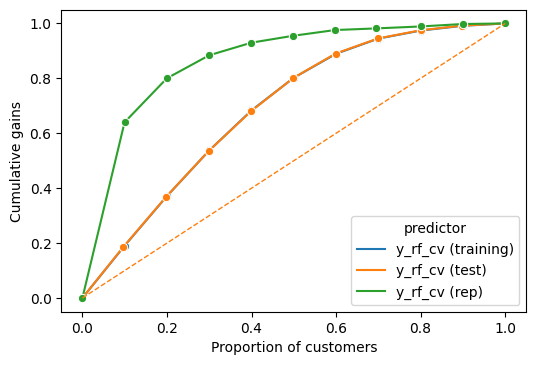

In [34]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
    "rep": eval_dat[eval_dat.training == -2147483648]
}

rsm.gains_plot(dct, rvar, lev, pred = 'y_rf_cv', qnt=10, marker="o")

No indication of overfitting - test and train align

## XG Boosted Tree

- case weights successfully applied in XGB
- cross validation has been completed with a range of hyper parameters to select one with highest AUC

In [35]:
clf_xgb = xgb.XGBClassifier(scale_pos_weight = 1/99, #case weights applied in XGB
    objective='binary:logistic',
    use_label_encoder=False,
    learning_rate = float,
    tree_method = str,
    eval_metric="auc",
    random_state=42) 
param_grid_xgb = {
    "max_depth": [4],
    #"max_depth": list(range(1, 5)), #cross validation has been completed with a range of hyper parameters to select one with highest AUC
    "n_estimators": [200],
    #"n_estimators": list(range(100, 401, 100)), #cross validation has been completed with a range of hyper parameters to select one with highest AUC
}
scoring = {"AUC": "roc_auc"}
param_grid_xgb

{'max_depth': [4], 'n_estimators': [200]}

In [36]:
clf_xgb_cv = GridSearchCV(
    clf_xgb, param_grid_xgb, scoring=scoring, cv=5, n_jobs=n_jobs, refit="AUC", verbose=5 
).fit(Xs_train, y_train.buyer_yes)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [37]:
print(clf_xgb_cv.best_params_)
print(clf_xgb_cv.best_score_)

{'max_depth': 4, 'n_estimators': 200}
0.8861579897959183


In [38]:
# predict for the entire dataset
eval_dat["y_xgb_cv"] = clf_xgb_cv.predict_proba(Xs)[:, 1]

#response rate for the representative sample:
print("Response rate for the representative sample is: ", round(eval_dat[eval_dat.training == -2147483648].y_xgb_cv.mean()*100 , 2), "%")

Response rate for the representative sample is:  1.36 %


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

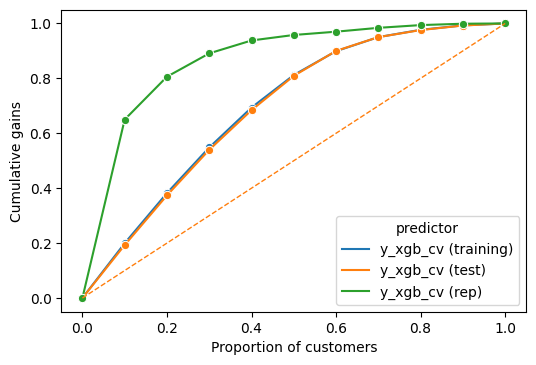

In [39]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0],
    "rep": eval_dat[eval_dat.training == -2147483648]
}

rsm.gains_plot(dct, rvar, lev, pred = 'y_xgb_cv', qnt=10, marker="o")

No indication of overfitting - test and train align

## Models Evaluation

In [40]:
rsm.evalbin(dct, rvar, lev, pred = ['y_glm','y_lasso', 'y_nn_cv', 'y_rf_cv','y_xgb_cv'], cost = 1, margin=2, dec=2)[['Type', 'predictor', 'total', 'AUC']]

,Type,predictor,total,AUC
0,training,y_glm,70000,0.88
1,training,y_lasso,70000,0.88
2,training,y_nn_cv,70000,0.89
3,training,y_rf_cv,70000,0.88
4,training,y_xgb_cv,70000,0.89
5,test,y_glm,30000,0.88
6,test,y_lasso,30000,0.88
7,test,y_nn_cv,30000,0.89
8,test,y_rf_cv,30000,0.88
9,test,y_xgb_cv,30000,0.89


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

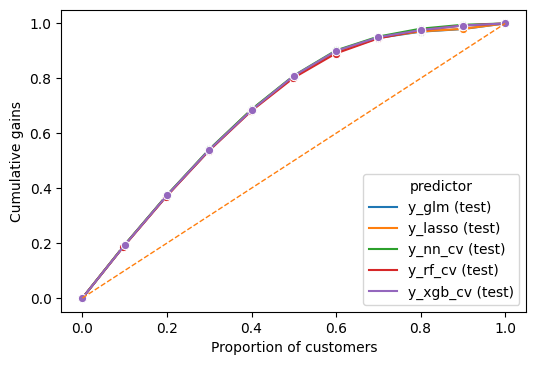

In [41]:
df = {
    "test": eval_dat[eval_dat.training == 0]
}

rsm.gains_plot(df, rvar, lev, pred = ['y_glm','y_lasso', 'y_nn_cv', 'y_rf_cv','y_xgb_cv'], qnt=10, marker="o")

- Because a breakeven metric is unavailable in the NPTB problem, AUC is the chosen metric to evaluate the models. <br>
- All models yield similar AUC (area under curve). <br>
- The sci kit learn models (NN, RF, Lasso Regression, XGB) could potentially outperform the statsmodel GLM provided tuning is done on a more comprehensive set of hyper parameters (i.e. greater resolution, more # of parameters) such that global optimum is not missed. Such computation is, however, very time intensive. <br>
- Without uncovering a global optimum on the sci kit learn models, unfortunately with a changed random state, model does not yield a unique solution. <br>

Case Weight correction:

- Neural network and random forest, which does not make use of case weights to correct predicted response rate commensurate to the population,consequently projected profits from these two models are unrealistically high. <br>

- The Scikit learn's lasso model did not apply interactions and basically all customers were assigned a message of Endurance, i.e., the message with highest average response rate. <br>

- The XGB Boost model is considered representative because case weights was applied correctly. With further refinement of hyper parameter tuning, the model could potentially meet or beat GLM/Statsmodel performance

## Projected Profit Calculations

A generalized linear model (GLM) with the statsmodel package was selected.

Interactions were included in this model such that predictions could be made specific to unique customer demographics and purchasing behaviour rather than assigning the one message (i.e. Endurance) that yielded maximum average profit. For eg. while females preferred endurance products over strength products, males showed similar preference for strength and endurance products and thus for males, the interaction model could accordingly more or less equally assign 'strength' and 'endurance' messages to males.

The GLM was then used to predict customer likelihood of purchase if every customer was assigned one of the 7 messages. If a particular message, say 'Strength' was sent to a customer, what would her/his likelihood of response be and how much could they be expected to pay? 

The message that yielded the highest likelihood of response for a particular customer was then selected as the message to offer. 

The following linear regression model predicts expected order size (EUR) based on the same factors used in the logistic model. Response variable is total order size (EUR).

In [97]:
logit_ordersize = "total_os ~ "
for feat in logit_features:
        logit_ordersize = logit_ordersize + feat + " + "

logit_ordersize = logit_ordersize[:-3]

lr_os = smf.ols(
 formula=logit_ordersize,
 data=pentathlon_nptb.query("training == 1"),
 freq_weights=pentathlon_nptb.query("training == 1")["cweight"],
).fit(cov_type="HC1")

In [98]:
pentathlon_nptb = pentathlon_nptb.assign(predicted_total_os=rsm.ifelse(lr_os.predict(pentathlon_nptb) >= 0, lr_os.predict(pentathlon_nptb), 0))

In [99]:
# Below code applies predictions from the Scikit learn models:

#model = lr_best
#model = clf_nn_cv
#model = clf_xgb_cv
#model = clf_rf

#caution: random forest (rf) model displays very good fit with training data, thus predictions on the training data set using rf will be exagerrated
#eval_dat.loc[eval_dat.training == 1, "y_rf_cv"] = clf_rf.oob_decision_function_[:, 1]
#eval_dat.loc[eval_dat.training == 0, "y_rf_cv"] = clf_rf.predict_proba(Xs_test)[:, 1]
#eval_dat.loc[eval_dat.training == -2147483648, "y_rf_cv"] = clf_rf.predict_proba(Xs_rep)[:, 1]

#pentathlon_nptb["p_endurance"] = model.predict_proba(Xs.assign(message_endurance = 1, message_strength = 0, message_water = 0, message_team = 0, message_backcountry = 0, message_winter = 0, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_strength"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 1, message_water = 0, message_team = 0, message_backcountry = 0, message_winter = 0, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_water"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 0, message_water = 1, message_team = 0, message_backcountry = 0, message_winter = 0, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_team"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 0, message_water = 0, message_team = 1, message_backcountry = 0, message_winter = 0, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_backcountry"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 0, message_water = 0, message_team = 0, message_backcountry = 1, message_winter = 0, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_winter"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 0, message_water = 0, message_team = 0, message_backcountry = 0, message_winter = 1, message_racquet = 0))[:, 1]
#pentathlon_nptb["p_racquet"] = model.predict_proba(Xs.assign(message_endurance = 0, message_strength = 0, message_water = 0, message_team = 0, message_backcountry = 0, message_winter = 0, message_racquet = 1))[:, 1]

In [100]:
# Below code applies predictions from GLM / Statsmodel:
# 
pentathlon_nptb["p_endurance"] = lr.predict(pentathlon_nptb.assign(message="endurance"))
pentathlon_nptb["p_strength"] = lr.predict(pentathlon_nptb.assign(message="strength"))
pentathlon_nptb["p_water"] = lr.predict(pentathlon_nptb.assign(message="water"))
pentathlon_nptb["p_team"] = lr.predict(pentathlon_nptb.assign(message="team"))
pentathlon_nptb["p_backcountry"] = lr.predict(pentathlon_nptb.assign(message="backcountry"))
pentathlon_nptb["p_winter"] = lr.predict(pentathlon_nptb.assign(message="winter"))
pentathlon_nptb["p_racquet"] = lr.predict(pentathlon_nptb.assign(message="racquet"))

pentathlon_nptb["os_endurance"] = lr_os.predict(pentathlon_nptb.assign(message="endurance"))
pentathlon_nptb["os_strength"] = lr_os.predict(pentathlon_nptb.assign(message="strength"))
pentathlon_nptb["os_water"] = lr_os.predict(pentathlon_nptb.assign(message="water"))
pentathlon_nptb["os_team"] = lr_os.predict(pentathlon_nptb.assign(message="team"))
pentathlon_nptb["os_backcountry"] = lr_os.predict(pentathlon_nptb.assign(message="backcountry"))
pentathlon_nptb["os_winter"] = lr_os.predict(pentathlon_nptb.assign(message="winter"))
pentathlon_nptb["os_racquet"] = lr_os.predict(pentathlon_nptb.assign(message="racquet"))

#### For each customer in the representative sample, the messages (one of endurance, strength, etc.) predicted to lead to the highest expected profit (COGS is 60%):

In [111]:
pentathlon_nptb["ep_endurance"] = pentathlon_nptb['p_endurance'] * 0.4 * pentathlon_nptb["os_endurance"]
pentathlon_nptb["ep_strength"] = pentathlon_nptb["p_strength"] * 0.4 * pentathlon_nptb["os_strength"]
pentathlon_nptb["ep_water"] = pentathlon_nptb["p_water"] * 0.4 * pentathlon_nptb["os_water"]
pentathlon_nptb["ep_team"] = pentathlon_nptb["p_team"] * 0.4 * pentathlon_nptb["os_team"]
pentathlon_nptb["ep_backcountry"] = pentathlon_nptb["p_backcountry"] * 0.4 * pentathlon_nptb["os_backcountry"]
pentathlon_nptb["ep_winter"] = pentathlon_nptb["p_winter"] * 0.4 * pentathlon_nptb["os_winter"]
pentathlon_nptb["ep_racquet"] = pentathlon_nptb["p_racquet"] * 0.4 * pentathlon_nptb["os_racquet"]

pentathlon_nptb["to_message_ep"] = (
    pentathlon_nptb[["ep_endurance", "ep_strength", "ep_water","ep_team" , "ep_backcountry", "ep_winter", "ep_racquet"]]
    .idxmax(axis=1)
    .str.replace("ep_endurance", "ENDURANCE")
    .replace("ep_strength", "STRENGTH")
    .replace("ep_water", "WATER")
    .replace("ep_team", "TEAM")
    .replace("ep_backcountry", "BACKCOUNTRY")
    .replace("ep_winter", "WINTER")
    .replace("ep_racquet", "RACQUET")
)

pentathlon_nptb.query('representative == 1')[['custid', 'to_message_ep']]

,custid,to_message_ep
0,U45198803,WATER
1,U22197752,WATER
3,U19423462,ENDURANCE
4,U23888305,STRENGTH
6,U16954857,RACQUET
...,...,...
199991,U12620333,WINTER
199993,U18623424,WATER
199994,U64468968,WATER
199998,U33721691,RACQUET


#### For each message, i.e., endurance, racket, etc., the percentage of customers for whom that message maximizes their expected profit:

In [102]:
print("Proportion of customers mailed in the 7 categories:")
    
pentathlon_nptb.query('representative == 1').to_message_ep.value_counts() / pentathlon_nptb.query('representative == 1').to_message_ep.value_counts().sum()

Proportion of customers mailed in the 7 categories:


ENDURANCE      0.25040
WATER          0.20880
STRENGTH       0.14064
WINTER         0.12459
RACQUET        0.10989
BACKCOUNTRY    0.10478
TEAM           0.06090
Name: to_message_ep, dtype: float64

#### Expected profit obtained, on average, per e-mailed customer if messages are customized:

In [103]:
pentathlon_nptb["ep_target"] = pentathlon_nptb[["ep_endurance", "ep_strength", "ep_water", "ep_team" , "ep_backcountry", "ep_winter", "ep_racquet"]].max(axis=1)

In [104]:
ans = (pentathlon_nptb.query('representative == 1')["ep_target"].agg("mean"))

print("Expected profit on average, per e-mailed customer if message customized to each customer: EUR", round(ans, 2))

Expected profit on average, per e-mailed customer if message customized to each customer: EUR 0.27


#### Expected profit per e-mailed customer if every customer receives the same message:

In [105]:
(
    pentathlon_nptb.query('representative == 1')[["ep_endurance", "ep_strength", "ep_water","ep_team" , "ep_backcountry", "ep_winter", "ep_racquet"]]
    .agg("mean")
    .sort_values(ascending=False)
    .apply(rsm.format_nr, sym="EUR ")
)

ep_strength       EUR 0.21
ep_endurance      EUR 0.21
ep_winter         EUR 0.19
ep_water          EUR 0.18
ep_backcountry    EUR 0.17
ep_racquet        EUR 0.17
ep_team           EUR 0.16
dtype: object

Note how the customized messaging offers higher profit (EUR 0.27) than if the each of the 7 messages were individually assigned.

#### Expected profit per e-mailed customer if every customer is assigned randomly to one of the seven messages:

In [106]:
#baseline = np.mean(pentathlon_nptb.query('representative == 1')['total_os'])

sample = pentathlon_nptb[["ep_endurance", "ep_strength", "ep_water","ep_team" , "ep_backcountry", "ep_winter", "ep_racquet"]]

indices = np.random.choice(np.arange(len(sample.columns)), len(sample), replace=True)

pentathlon_nptb['ep_random'] = sample.to_numpy()[np.arange(len(sample)), indices]

baseline = pentathlon_nptb.query('representative == 1')["ep_random"].agg("mean")

print("Expected profit per e-mailed customer if every customer is assigned randomly to one of the seven messages: EUR", round(baseline, 2))

Expected profit per e-mailed customer if every customer is assigned randomly to one of the seven messages: EUR 0.19


#### For the typical promotional e-mail blast to 5,000,000 customers, Pentathlon can achieve the following improvement by customizing the message to each customer rather than assigning customers a message randomly:

In [107]:
ans3 = (pentathlon_nptb.query('representative == 1')["ep_target"].agg("mean")  - baseline) * 100 / baseline

print("% Improvement in profit by customizing the message to each customer rather than assigning customers a message randomly: ", round(ans3, 2), "%")

% Improvement in profit by customizing the message to each customer rather than assigning customers a message randomly:  44.02 %


In [132]:
ans4 = (pentathlon_nptb.query('representative == 1')["ep_target"].agg("mean")  - baseline) * 5000000

print("Improvement in profit by customizing the message to each customer rather than assigning customers a message randomly: EUR", round(ans4, 2))

Improvement in profit by customizing the message to each customer rather than assigning customers a message randomly: EUR 409119.75


In [128]:
a = pentathlon_nptb.query('representative == 1')["ep_target"].agg("mean") * 100000
a

26770.451375804532

In [129]:
b = baseline * 100000
b

18588.056332546843

In [130]:
a-b

8182.395043257689

In [131]:
(a-b) / b

0.44019637647270776